In [1]:
import re
import string
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from underthesea import word_tokenize
from gensim.models import KeyedVectors, Word2Vec
from gensim.utils import simple_preprocess

from keras.models import Sequential 
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU, Bidirectional

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
data = pd.read_csv('data/train.csv', header=None, names=['classes', 'content'])
data.head()

,classes,content
0,0,máy dùng hay bị đơ máy
1,0,chỉ có dây cáp nguồn không có adapter sao sử d...
2,0,Chất lượng quá kém Mới dùng được 2 ngày loa ba...
3,0,Usb tôi vừa mới nhận usb này Rất bực bội vì cá...
4,2,Tuyệt vời. Hàng FPT cửa hàng


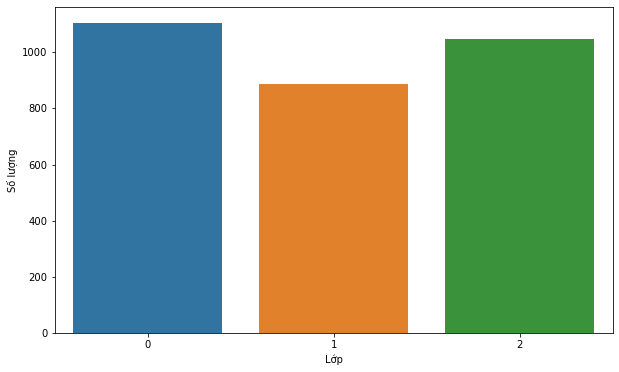

In [3]:
plt.figure(figsize=(10, 6))
x = data['classes'].unique()
y = data['classes'].value_counts()
sns.barplot(x=x, y=y)
plt.xlabel('Lớp')
plt.ylabel('Số lượng')
plt.show()

In [4]:
def clean_text(text):
    my_punct = '[!"\#\$%\&\(\)\*\+,/:;<=>\?@\[\\\]\^_—`.\{\|\}\~»«“”]'
    trans = str.maketrans('', '', my_punct)
    text = text.translate(trans)
    text = text.lower().split()
    text = ' '.join(text)
    return text

def remove_emojis(string):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f" 
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', string)

data['content'] = data['content'].map(lambda x: clean_text(x))
data['content'] = data['content'].map(lambda x: remove_emojis(x))

In [5]:
original_stopwords = ['tiki']

def create_stopwords(path):
    with open(path, encoding='utf-8') as words:
        return [w[:len(w) - 1] for w in words] + original_stopwords
    
stopwords = create_stopwords('data/vietnamese_stopwords_dash.txt')

In [6]:
def word_preprocessing(sen):
    sen = " ".join(simple_preprocess(sen))
    sen = [w for w in word_tokenize(sen.lower(), format='text').split() \
         if w not in stopwords]
    return [w for w in sen if w != '']

In [7]:
corpus = data['content'].values.tolist()
corpus = list(map(word_preprocessing, corpus))

In [8]:
data['list_words'] = corpus
data['count'] = data['list_words'].map(lambda x: len(x))

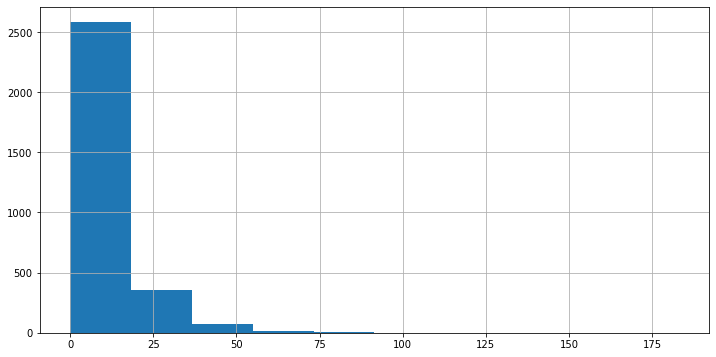

In [9]:
plt.figure(figsize=(12, 6))
data['count'].hist();

In [10]:
vocab, index = {}, 1
vocab['<pad>'] = 0
max_words = 0

for sen in corpus:
    for word in sen:
        if word not in vocab:
            vocab[word] = len(vocab)
    len_sen = len(sen)
    if max_words < len_sen:
        max_words = len_sen
            
inverse_vocab = {idx: word for word, idx in vocab.items()}
vocab_size = len(vocab)
print('vocab size:', vocab_size)
print('max lenghts:', max_words)

vocab size: 3718
max lenghts: 183


In [11]:
# word2vec = KeyedVectors.load_word2vec_format('data/baomoi.vn.model.bin', binary=True)
# word2vec_weights = word2vec.vectors
# embedding_dims = word2vec_weights.shape[1]
# print('embedding dims:', embedding_dims)

In [12]:
# vocab = word2vec.key_to_index
# inverse_vocab = word2vec.index_to_key
# vocab_size = len(vocab)
# vocab_size

In [13]:
matrix_wv = []
for sen in corpus:
    matrix_wv.append([vocab[word] for word in sen])

In [14]:
X = pad_sequences(matrix_wv, maxlen=max_words, value=0, padding='post')
X

array([[   1,    2,    1, ...,    0,    0,    0],
       [   3,    4,    3, ...,    0,    0,    0],
       [   8,    9,   10, ...,    0,    0,    0],
       ...,
       [  86,   61,   71, ...,    0,    0,    0],
       [  71,    5, 2187, ...,    0,    0,    0],
       [  23,   85, 2334, ...,    0,    0,    0]])

In [15]:
y = data['classes']
y = pd.get_dummies(y).values.astype(float)
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [16]:
xtrain, xval, ytrain, yval = train_test_split(X, y, test_size=.1, random_state=42)
xtrain.shape, ytrain.shape, xval.shape, yval.shape

((2736, 183), (2736, 3), (304, 183), (304, 3))

In [17]:
embedding_idx = fasttext.load_model('data/cc.vi.300.bin')

In [18]:
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocab.items():
    embedding_vector = embedding_idx[word]
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3718 words (0 misses)


In [19]:
embedding_matrix.shape

(3718, 300)

In [20]:
model = Sequential()

embedding_layer = Embedding(
    vocab_size,
    embedding_dim,
    input_length=max_words,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False,
)

model.add(embedding_layer)
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 183, 300)          1115400   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              186880    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,302,667
Trainable params: 187,267
Non-trainable params: 1,115,400
_________________________________________________________________


In [21]:
model.compile(
    loss= 'categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)

In [22]:
train_history = model.fit(
    xtrain, 
    ytrain, 
    batch_size=32, 
    epochs=10, 
    validation_data=(xval, yval)
)

Epoch 1/10
86/86 [==============================] - 17s 127ms/step - loss: 1.0152 - accuracy: 0.4989 - val_loss: 0.8954 - val_accuracy: 0.5987
Epoch 2/10
86/86 [==============================] - 10s 121ms/step - loss: 0.8594 - accuracy: 0.6177 - val_loss: 0.8470 - val_accuracy: 0.6118
Epoch 3/10
86/86 [==============================] - 11s 125ms/step - loss: 0.7920 - accuracy: 0.6528 - val_loss: 0.8167 - val_accuracy: 0.6151
Epoch 4/10
86/86 [==============================] - 10s 119ms/step - loss: 0.7432 - accuracy: 0.6791 - val_loss: 0.8143 - val_accuracy: 0.6316
Epoch 5/10
86/86 [==============================] - 10s 119ms/step - loss: 0.7080 - accuracy: 0.6977 - val_loss: 0.7962 - val_accuracy: 0.6546
Epoch 6/10
86/86 [==============================] - 10s 118ms/step - loss: 0.6779 - accuracy: 0.7149 - val_loss: 0.8013 - val_accuracy: 0.6151
Epoch 7/10
86/86 [==============================] - 10s 118ms/step - loss: 0.6547 - accuracy: 0.7113 - val_loss: 0.7920 - val_accuracy: 0.6711

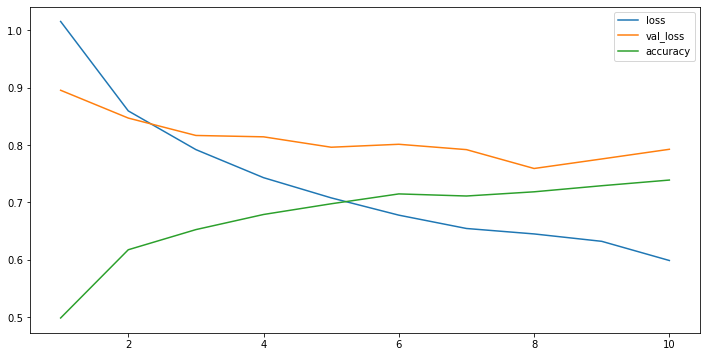

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 11), train_history.history['loss'], label='loss')
plt.plot(range(1, 11), train_history.history['val_loss'], label='val_loss')
plt.plot(range(1, 11), train_history.history['accuracy'], label='accuracy')
plt.legend()
plt.show()

In [42]:
# 34 -> 3, 25 -> 1
idx = 34
pred = model.predict(xval)[idx]
print('Prob:', pred)
print('Class:', pred.argmax()+ 1)
print('text:', [inverse_vocab[index] for index in xval[idx] if inverse_vocab[index] != inverse_vocab[0]])

Prob: [2.6579370e-04 6.5952833e-03 9.9313897e-01]
Class: 3
text: ['giá', 'rẻ', 'chất_lượng', 'văn_phòng', 'hợp_lý']


In [43]:
def pred(text):
    text = clean_text(text)
    text = remove_emojis(text)
    tokens = word_preprocessing(text)
    X = pad_sequences([[vocab[word] for word in tokens]], maxlen=max_words, value=0, padding='post')
    pred = model.predict(X)
    print('Prob:', pred)
    print('Class:', pred.argmax()+ 1)
    print('text:', [inverse_vocab[idx] for idx in X.ravel() if inverse_vocab[idx] != inverse_vocab[0]])

In [44]:
pred('đóng gói hàng rất tệ')

Prob: [[0.8081424  0.11977336 0.0720842 ]]
Class: 1
text: ['đóng', 'gói', 'hàng', 'tệ']
